# The Financial Effects of Hospital System Affiliation

This project answers the following question: **What is the effect on hospital financial performance when a hospital becomes affiliated with (or switches into) a hospital system?**

Understanding this effect is important because hospital system affiliation is often motivated by financial pressures, access to capital, and potential efficiency gains. At the same time, hospitals that choose to join systems may already differ systematically from those that remain independent, making careful empirical analysis essential.

To address this question, I use a hospital-level panel dataset and an event-study framework that compares hospitals before and after system entry, while controlling for hospital fixed effects, time effects, and other control variables. This approach allows me to isolate changes in financial performance that coincide with the timing of system affiliation, under the standard parallel-trends assumption.


I find that hospital net income margins increase by approximately **2.3** percentage points in the year a hospital joins a system. This effect is  meaningful: the estimated increase is almost **twice as large (60%)** as the average net margin observed among treated hospitals before system entry.

## 0. Department of Health Care Access and Information (HCAI) Pivot Data


The [Hospital Annual Financial Data Pivot Tables dataset from HCAI](https://data.ca.gov/dataset/hospital-annual-financial-data-selected-data-pivot-tables) contains facility-level annual financial and utilization information for hospitals licensed in California. This publicly available data is submitted by hospitals as part of required annual financial disclosure reporting and includes detailed revenue, expense, balance sheet, utilization, and capacity measures. It enables comparative and trend analysis of hospital financial performance across years, including profitability, payer mix, operating costs, and resource utilization.
 
I downloaded the "Pivot Table - Hospital Annual Selected File" for each year between 1995 and 2024:

- **Sone Key Fields:**
    - **Hospital identifiers and structure**
        - fac_no: unique HCAI hospital facility identifier.
        - fac_name: hospital name.
        - county: county in which the hospital is located.
        - hsa_name: health service area.
        - hfpa: health facility planning area.
  
    - **Time variables**
        - year: reporting year (constructed using file year).
        - beg_date: beginning of the report period.
        - end_date: end of the report period.

    - **System affiliation and treatment variables (I construct these)**
        - system (≥ 3 hosp): reported health system name (non-missing indicates system affiliation).
        - in_system: indicator for system affiliation.
        - switch_system: indicator for transition from independent to system-affiliated.
        - treated: an indicator for hospitals that ever enter a system.
        - event_year: first year of system entry.
        - event_time: years relative to system entry.

    - **Financial performance variables**
        - net_pt_rev: net patient revenue.
        - oth_op_rev: other operating revenue.
        - net_income: net income.
        - net_frm_op: net income from operations.
        - tot_op_exp: total operating expenses.

    - **Capacity and utilization**
        - bed_lic: number of licensed hospital beds.
        - dis_tot: total inpatient discharges.
        - vis_tot: total outpatient visits.

    - **Payer-specific utilization**
        - day_mcal_tr: medi-cal traditional patient days.
        - day_mcal_mc: medi-cal managed care patient days.
        - day_mcar_tr: medicare traditional patient days.
        - day_mcar_mc: medicare managed care patient days.
        - day_tot: total patient days.

First, lets load libraries and some general housekeeping

In [1]:
#Housekeeping
import sys 
import os
import re
#Import functions stored in a folder (custom) 
import sys 
#sys.path.append("directoryname") 
import time
import pandas as pd
import numpy as np
from glob import glob
import seaborn as sns
from scipy import stats
import pyreadstat 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


clear = lambda: os.system('cls')
clear()

#Define main path and output path to export results
os.chdir('G:/My Drive/Projects/Diff in Diff')
out_path   = "./Output/"
os.makedirs(out_path, exist_ok=True)

Let's import and append all years of the HCAI data.

 

# 1. Importing the HCAI Financial Pivot Data

Given the data size, it is desirable to first aggregate each chunk, and then to append all aggregated bits accordingly. To achieve this, I:
1. Start with all the excel files saved into a single path.
2. Load (and append) the excels sequentially.
    -Note: I handle 2024 separately because it comes as an .xlsm file rather than .xls. I locate it explicitly, read the same Data sheet, and assign year = 2024 so it matches the structure of the earlier files.
3. Concatenate everything into a single dataset: first I combine the 1995–2023 files from the list into one DataFrame, then append the 2024 file to produce a unified dataset (hcai_data) with hospital-year observations.
 

In [2]:
#First, let's define filepaths 
raw_path   = "./Data/"
os.makedirs(raw_path, exist_ok=True)

excel_files = glob(os.path.join(raw_path, "*.xls"))

display(print(f"Found {len(excel_files)} raw postings files."))

#Append all data
dfs = []
for file in excel_files:
    print("Loading:", file)
    #Extract Years
    match = re.search(r'(\d{4})', file)
    year = int(match.group(1))
    df = pd.read_excel(file,sheet_name="Data")
    df["year"] = year
    dfs.append(df)

#ADD 2024 (is an xlsm instead)
file_excel_2024 =  glob(os.path.join(raw_path, "hafd2024pivot.xlsm") )
excel_2024 =  pd.read_excel(file_excel_2024[0],sheet_name="Data")
df["year"] = 2024 
 
# Append into a single DataFrame
hcai_data_1995_2023 = pd.concat(dfs, ignore_index=True)
hcai_data = pd.concat([hcai_data_1995_2023, excel_2024],ignore_index=True )

#hcai_data_clean = hcai_data.clean_names()
print("Combined shape:", hcai_data.shape)
display(hcai_data)

Found 29 raw postings files.


None

Loading: ./Data\hafd2023pivot.xls
Loading: ./Data\hafd2019pivot.xls
Loading: ./Data\hafd2018pivot.xls
Loading: ./Data\hafd2017pivot.xls
Loading: ./Data\hafd2013pivot.xls
Loading: ./Data\hafd2012pivot.xls
Loading: ./Data\hafd2014pivot.xls
Loading: ./Data\hafd2016pivot.xls
Loading: ./Data\hafd2015pivot.xls
Loading: ./Data\hafd2008pivot.xls
Loading: ./Data\hafd2007pivot.xls
Loading: ./Data\hafd2006pivot.xls
Loading: ./Data\hafd2005pivot.xls
Loading: ./Data\hafd2004pivot.xls
Loading: ./Data\hafd2003pivot.xls
Loading: ./Data\hafd2002pivot.xls
Loading: ./Data\hafd2001pivot.xls
Loading: ./Data\hafd2000pivot.xls
Loading: ./Data\hafd1999pivot.xls
Loading: ./Data\hafd1998pivot.xls
Loading: ./Data\hafd1997pivot.xls
Loading: ./Data\hafd1996pivot.xls
Loading: ./Data\hafd1995pivot.xls
Loading: ./Data\hafd2011pivot.xls
Loading: ./Data\hafd2010pivot.xls
Loading: ./Data\hafd2009pivot.xls
Loading: ./Data\hafd2020pivot.xls
Loading: ./Data\hafd2021pivot.xls
Loading: ./Data\hafd2022pivot.xls
Combined shape

,FAC_NO,FAC_NAME,BEG_DATE,END_DATE,DAY_PER,county name,HSA name,HFPA,TYPE_CNTRL,SYSTEM (≥ 3 HOSP),...,TOT_LTDEBT,CUR_MAT,ner a/r (calc),nurs fte,prod fte,paid fte,hsa name,Health System,COUNTY,HSA
0,106010735.0,ALAMEDA HOSPITAL,2022-07-01 00:00:00,2023-06-30 00:00:00,365.0,Alameda,05 - EAST BAY,417.0,City/County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,106010739.0,ALTA BATES SUMMIT MEDICAL CENTER - ALTA BATES ...,2023-01-01 00:00:00,2023-12-31 00:00:00,365.0,Alameda,05 - EAST BAY,415.0,Non-Profit,SUTTER HEALTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,106010776.0,UCSF BENIOFF CHILDREN'S HOSPITAL OAKLAND,2022-07-01 00:00:00,2023-06-30 00:00:00,365.0,Alameda,05 - EAST BAY,417.0,Non-Profit,UNIVERSITY OF CALIFORNIA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,106010846.0,HIGHLAND HOSPITAL,2022-07-01 00:00:00,2023-06-30 00:00:00,365.0,Alameda,05 - EAST BAY,417.0,City/County,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,106010887.0,KINDRED HOSPITAL - SAN FRANCISCO BAY AREA,2023-01-01 00:00:00,2023-12-31 00:00:00,365.0,Alameda,05 - EAST BAY,421.0,Investor,SCIONHEALTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13513,106444013.0,WATSONVILLE COMMUNITY HOSPITAL,2024-01-01 00:00:00,2024-12-31 00:00:00,366.0,Santa Cruz,08 - MID-COAST,711.0,Non-Profit,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13514,106301379.0,WEST ANAHEIM MEDICAL CENTER,2024-01-01 00:00:00,2024-12-31 00:00:00,366.0,Orange,13 - ORANGE COUNTY,1012.0,Investor,PRIME HEALTHCARE SERVICES,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13515,106190883.0,WHITTIER HOSPITAL MEDICAL CENTER,2023-07-01 00:00:00,2024-06-30 00:00:00,366.0,Los Angeles,11 - LOS ANGELES COUNTY,919.0,Investor,"AHMC HEALTHCARE, INC.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13516,106571086.0,WOODLAND MEMORIAL HOSPITAL,2023-07-01 00:00:00,2024-06-30 00:00:00,366.0,Yolo,02 - GOLDEN EMPIRE,313.0,Non-Profit,DIGNITY HEALTH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Define the estimator, treatment and Outcome variables

In more technical terms, the goal of this project is to estimate the **Average Treatment Effect (ATE)** of hospital system affiliation on financial performance. Conceptually, the ATE compares a hospital’s financial outcomes after joining a system to the outcomes that same hospital would have experienced had it remained independent.
Formally, let:


- $Y_{it}(1)$ denote the potential outcome for hospital $i$ in year $t$ if the hospital is affiliated with a system. 
- $Y_{it}(0)$ denote the potential outcome for hospital $i$ in year $t$ if the hospital is not affiliated with a system. 



The ATE is defined as:

$$
\text{ATE} = \mathbb{E}\left[ Y_{it}(1) - Y_{it}(0) \right]
$$

**The main problem to solve is that $Y_{it}(0)$ is not observed for hospitals after they join a system, so a counterfactual must be estimated.** To achieve this, I explain the technique below.

##  2.1 Difference-in-Differences and Event-Study Identification

I estimate the ATE using a **difference-in-differences (DiD) event-study design**, which exploits variation in the timing of hospital system entry across hospitals.

Let:

- $D_{it} = 1$ if hospital $i$ has joined a system by year $t$, and $0$ otherwise  
- $\alpha_i$ denote hospital fixed effects  
- $\lambda_t$ denote year fixed effects  

The event-study specification is:

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{k \neq -1} \beta_k \cdot \mathbf{1}\{\text{event\_time}_{it} = k\} + \varepsilon_{it}
$$

where:

- $\text{event\_time}_{it} = t - t_i^{*}$  
- $t_i^{*}$ is the year hospital $i$ first joins a system  
- $k$ indexes years relative to system entry  
- the year immediately before treatment ($k = -1$) is omitted and serves as the reference period  

Under the **parallel trends assumption**, the post-treatment coefficients $\beta_k$ identify the causal effect of hospital system affiliation.



## 2.2 Treatment Definition and Outcome Variables

The treatment is defined as a hospital joining a health system operating three or more hospitals in year $t$.

I construct an indicator for system affiliation, identify the first year of entry into a system, and define event time as years relative to this entry.

Also, I study the following Financial outcomes

- Operating margin:     operating Income / total operating revenue

- Net Income margin: Net Income / total revenue
  
- Cost To Charge Ratio: Operating Cost net of Other operating revenue divided by gross patiewnt revenue.  

- Cost intensity: Operating Expenses / Discharges  

I implement these definitions in the code below.

In [3]:
#Define Treatment variable
panel_df = hcai_data.sort_values(["FAC_NO", "year"])

panel_df["system"] = panel_df["SYSTEM (≥ 3 HOSP)"].fillna("INDEPENDENT_or_<3")
panel_df["system_lag"] = panel_df.groupby("FAC_NO")["system"].shift(1)


panel_df["system_raw"] = panel_df["SYSTEM (≥ 3 HOSP)"]
panel_df["in_system"] = panel_df["system_raw"].notna().astype(int)
panel_df["in_system_lag"] = panel_df.groupby("FAC_NO")["in_system"].shift(1)

# Event: first time entering a system (0 -> 1)
panel_df["switch_system"] = ((panel_df["in_system_lag"] == 0) & (panel_df["in_system"] == 1)).astype(int)


#Define Treatment variable
panel_df["treated"] = panel_df.groupby("FAC_NO")["switch_system"].transform("max") 
#Compute the event year per hospital and add to the main dataset
event_year = (
    panel_df
    .loc[panel_df["switch_system"] == 1]
    .groupby("FAC_NO")["year"]
    .min()
    .rename("event_year")
)


print(panel_df["treated"].value_counts())
panel_df = panel_df.merge(event_year, on="FAC_NO", how="left")
panel_df["event_time"] = panel_df["year"] - panel_df["event_year"]

#unique_categories = panel_df["independent"].unique()
#print(unique_categories)
#Define Outcome Variables
panel_df["tot_op_rev"] = panel_df["NET_PT_REV"] + panel_df["OTH_OP_REV"]

# 1) Operating margin = Net income from operations / total operating revenue
panel_df["operating_margin"] = panel_df["NET_FRM_OP"]/ panel_df["tot_op_rev"]

# 2) Net income margin = Net income / (net patient rev + other op rev + nonop rev)
panel_df["total_revenue_incl_nonop"] = panel_df["tot_op_rev"] + panel_df["NONOP_REV"]
panel_df["net_income_margin"]        = panel_df["NET_INCOME"]/ panel_df["total_revenue_incl_nonop"]

# 3) Cost-to-charge ratio = (Total op exp - other op rev) / gross patient revenue
panel_df["cost_to_charge_ratio"] = (panel_df["TOT_OP_EXP"] - panel_df["OTH_OP_REV"])/ panel_df["GR_PT_REV"]

# 4) Cost Intensity 
panel_df["cost_per_discharge"] = np.where(
    (panel_df["DIS_TOT"].isna()) | (panel_df["DIS_TOT"] == 0),
    np.nan,
    panel_df["TOT_OP_EXP"] / panel_df["DIS_TOT"]
)



#Additional variables 
#Payment Mix
panel_df["mcal_share"] = (panel_df["DAY_MCAL_TR"] + panel_df["DAY_MCAL_MC"]) / panel_df["DAY_TOT"]
panel_df["mcar_share"] = (panel_df["DAY_MCAR_TR"] + panel_df["DAY_MCAR_MC"]) / panel_df["DAY_TOT"]
print(panel_df) 

treated
1.0    8124
0.0    5393
Name: count, dtype: int64
            FAC_NO                      FAC_NAME             BEG_DATE  \
0      106010735.0              ALAMEDA HOSPITAL                  NaN   
1      106010735.0              ALAMEDA HOSPITAL                  NaN   
2      106010735.0              ALAMEDA HOSPITAL                  NaN   
3      106010735.0              ALAMEDA HOSPITAL                  NaN   
4      106010735.0              ALAMEDA HOSPITAL                  NaN   
...            ...                           ...                  ...   
13513  106580996.0  ADVENTIST HEALTH AND RIDEOUT  2021-01-01 00:00:00   
13514  106580996.0  ADVENTIST HEALTH AND RIDEOUT  2023-01-01 00:00:00   
13515  106580996.0  ADVENTIST HEALTH AND RIDEOUT  2022-01-01 00:00:00   
13516  106580996.0  ADVENTIST HEALTH AND RIDEOUT  2024-01-01 00:00:00   
13517          NaN                           NaN                  NaT   

                  END_DATE  DAY_PER county name            HSA na

C:\Users\ja21_\AppData\Local\Temp\ipykernel_29388\2927848962.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  panel_df["system"] = panel_df["SYSTEM (≥ 3 HOSP)"].fillna("INDEPENDENT_or_<3")
C:\Users\ja21_\AppData\Local\Temp\ipykernel_29388\2927848962.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  panel_df["system_lag"] = panel_df.groupby("FAC_NO")["system"].shift(1)
C:\Users\ja21_\AppData\Local\Temp\ipykernel_29388\2927848962.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

# 3. Descriptive Statistics

Now let's clean missing values and run some descriptive statistics to look at the data that we are dealing with:

In [4]:
#Now let's drop na, summarise the outcome and treatment variables
outcomes = ["operating_margin","net_income_margin","cost_to_charge_ratio","cost_per_discharge"]

panel_df_clean = (
    panel_df
    .replace([np.inf, -np.inf], np.nan)   
    .dropna(subset=outcomes)
) 
# Let's windzorise outcome variables too
for v in outcomes:
 lo, hi = panel_df_clean[v].quantile([0.02, 0.98])
 panel_df_clean[v] = panel_df_clean[v].clip(lo, hi)
 

print("Descriptive Statistics for Outcome Variables:")
print(panel_df_clean[outcomes].describe())

#Now lets summarise the treatment variable
N_obs = len(panel_df_clean)
N_hosp = panel_df_clean["FAC_NO"].nunique()
N_events = panel_df_clean["switch_system"].sum()
event_rate = panel_df_clean["switch_system"].mean()

ever_treated = panel_df_clean.groupby("FAC_NO")["switch_system"].max()
N_ever_treated = ever_treated.sum()

switch_years = panel_df_clean.loc[panel_df_clean.switch_system == 1, "year"]

#Summary Statistics for treatment variable.
treatment_summary = pd.DataFrame({
    "Statistic": [
        "Hospital-years",
        "Hospitals",
        "Switch events",
        "Event rate (hospital-year)",
        "Hospitals ever switching",
        "First switch year",
        "Last switch year"
    ],
    "Value": [
        N_obs,
        N_hosp,
        int(N_events),
        round(event_rate, 4),
        int(N_ever_treated),
        int(switch_years.min()) if len(switch_years) > 0 else None,
        int(switch_years.max()) if len(switch_years) > 0 else None
    ]
})
print("Descriptive Statistics for Treatment Variable:")
print(treatment_summary)

print("Descriptive Statistics for Event Timing:")
print(panel_df_clean["event_time"].describe())

Descriptive Statistics for Outcome Variables:
       operating_margin  net_income_margin  cost_to_charge_ratio  \
count      12802.000000       12802.000000          12802.000000   
mean          -0.017996           0.023994              0.405265   
std            0.176492           0.125268              0.231116   
min           -0.769381          -0.403427              0.128554   
25%           -0.061050          -0.023347              0.238315   
50%            0.010111           0.030855              0.331640   
75%            0.073290           0.092650              0.499828   
max            0.265380           0.291121              1.037215   

       cost_per_discharge  
count        12802.000000  
mean         31945.535524  
std          41274.135209  
min           4155.582886  
25%          10478.387466  
50%          18590.900462  
75%          34746.293307  
max         237197.147220  
Descriptive Statistics for Treatment Variable:
                    Statistic       Value


The analysis sample consists of 12,802 hospital-year observations across 646 hospitals (between 1995 and 2024), after trimming extreme values at the 2nd and 98th percentiles.

On average, hospitals exhibit a negative operating margin (−1.8%) but a positive net income margin (2.4%), indicating that non-operating revenues play an important role in overall financial performance. The large dispersion in both margins highlights substantial heterogeneity across hospitals. The cost-to-charge ratio averages 0.41, while cost per discharge averages approximately $31,900, with wide variation across facilities, reflecting differences in scale, case mix, and intensity of care.

System entry is relatively rare, with 288 entry events affecting 268 hospitals, corresponding to a 2.25% hospital-year event rate. Most hospitals enter a system only once, consistent with system affiliation being a largely irreversible decision. Entry events occur between 2017 and 2024, concentrating treatment in the later part of the sample.

The distribution of event timing shows a long pre-treatment window (median event time of −8 years) and several post-treatment years for many hospitals. This supports the use of an event-study design, allowing for credible assessment of pre-trends and dynamic treatment effects.

## 3.1 Pre-Treatment Differences

Before estimating treatment effects, it is important to examine whether hospitals that eventually join a system differ systematically from hospitals that remain independent prior to treatment. These pre-treatment differences provide insight into selection into system affiliation and help assess the plausibility of the identifying assumptions underlying the event-study design.

In [5]:
pre = panel_df_clean[(panel_df_clean["event_time"] < 0) | (panel_df_clean["treated"] == 0)]


#print(pre)
balance = (
    pre
    .groupby("treated")[outcomes]
    .agg(["mean", "std"])
)
 
print(balance)

#Standardized Differences
def std_diff(x_t, x_c):
    return (x_t.mean() - x_c.mean()) / np.sqrt(0.5 * (x_t.var() + x_c.var()))

std_diffs = {
    v: std_diff(pre.loc[pre.treated == 1, v],
                pre.loc[pre.treated == 0, v])
    for v in outcomes
}

print(std_diffs)

        operating_margin           net_income_margin            \
                    mean       std              mean       std   
treated                                                          
0.0            -0.063276  0.201035          0.003888  0.128696   
1.0             0.014162  0.147510          0.039296  0.115774   

        cost_to_charge_ratio           cost_per_discharge                
                        mean       std               mean           std  
treated                                                                  
0.0                 0.510327  0.264233       40478.690211  55878.828597  
1.0                 0.343155  0.164460       19818.031044  18744.281899  
{'operating_margin': 0.4392019913980789, 'net_income_margin': 0.2892660723932149, 'cost_to_charge_ratio': -0.7596093472387215, 'cost_per_discharge': -0.4957438000843327}



The balance table shows that, prior to system entry, hospitals that eventually join a system differ meaningfully from never-treated hospitals:

- Treated hospitals have higher pre-treatment operating margins (1.4% vs. −6.3%) and higher net income margins (3.9% vs. 0.4%).
- Treated hospitals exhibit lower cost-to-charge ratios (0.34 vs. 0.51), suggesting lower costs relative to charges.
- Treated hospitals have substantially lower cost per discharge (about $19,800 vs. $40,500), consistent with differences in scale, efficiency, or case mix.

These differences indicate that hospitals entering systems are not observationally identical to those that remain independent even before treatment.

The standardized differences quantify the magnitude of these gaps relative to within-group variation:

- Operating margin: 0.44
- Net income margin: 0.29
- Cost-to-charge ratio: −0.76
- Cost per discharge: −0.50

Values of this magnitude indicate moderate to large pre-treatment imbalance, particularly for cost-based measures. This pattern suggests non-random selection into system affiliation, with treated hospitals appearing financially stronger and more cost-efficient prior to entry.

This finding suggests that affiliating hospitals look different even before affiliation (hospitals in a system seem to be more profitable across all metrics before treatment), so we must rely on trends, not levels, for identification. These pre-treatment differences underscore why level comparisons are not informative for causal inference in this setting. However, difference-in-differences and event-study designs do not require treated and control hospitals to have identical pre-treatment levels. Instead, identification relies on the parallel trends assumption—that absent treatment, outcomes for treated and control hospitals would have evolved similarly over time.

Accordingly, the presence of pre-treatment level differences heightens the importance of:

- Hospital fixed effects to absorb time-invariant differences
- Event-study pre-trend tests to assess whether treated and control hospitals followed similar trends prior to system entry.

# 4. Event-study pre-trends and dynamic effects

To study both **pre-trends** and **dynamic post-treatment effects**, I estimate an event-study difference-in-differences model using a symmetric window around the treatment event. Specifically, I focus on a **±3-year window** around the first year in which a hospital enters a multi-hospital system, so event time takes values \(k \in \{-3,-2,-1,0,1,2,3\}\).

I construct indicator variables for each event-time \(k\), but **omit \(k = -1\)** (the year immediately prior to system entry). Omitting this period normalizes the model so that it serves as the **baseline**, which implies that all event-study coefficients are interpreted **relative to the year just before treatment**. This normalization is standard in event-study designs and facilitates a clear interpretation of both pre-treatment and post-treatment dynamics.

The event-study regression includes **hospital fixed effects** to absorb time-invariant differences across hospitals—such as persistent differences in size, mission, or market position—and **year fixed effects** to absorb shocks common to all hospitals in a given year, including policy changes and macroeconomic conditions.

I estimate two specifications. **Spec 1 (baseline)** includes only the event-time indicators and fixed effects. **Spec 2 (controls)** augments the baseline specification with time-varying hospital controls capturing scale, utilization, and payer mix, including licensed beds (*BED_LIC*), total discharges (*DIS_TOT*), total outpatient visits (*VIS_TOT*), and the shares of patient days attributable to Medi-Cal and Medicare (*mcal_share*), \(*mcar_share*). These controls account for observable changes in hospital activity and payer composition over time.

Standard errors are **clustered at the hospital level** to allow for serial correlation in outcomes within hospitals. The primary credibility check in this framework is the pattern of the **lead coefficients** (event times \(k<0\)): estimates close to zero support the parallel trends assumption. The **post-treatment coefficients.** Event times $(k \ge 0)$ trace out the dynamic effects of system entry on hospital financial outcomes.


In [6]:
event_window = (-3, 3)

# Keep treated hospitals + never-treated controls
es_df = panel_df_clean.copy()

column_names_list = es_df.columns.tolist()

#print(column_names_list)

# Keep treated hospitals within the window + never-treated controls
es_df = es_df[
    (es_df["event_time"].between(event_window[0], event_window[1])) |
    (es_df["treated"] == 0)
].copy()


#This function defines the variable coefficient names
def evname(k):
    if k < 0:
        return f"event_m{abs(k)}"
    elif k > 0:
        return f"event_p{k}"
    else:
        return "event_0"

# Create dummies, omit -1 as reference
for k in range(event_window[0], event_window[1] + 1):
    if k == -1:
        continue
    es_df[evname(k)] = (es_df["event_time"] == k).astype(int)

event_terms = " + ".join([evname(k) for k in range(event_window[0], event_window[1] + 1) if k != -1])

#controls = ["BED_LIC", "DIS_TOT", "VIS_TOT"]  # Control Variables
controls = ["BED_LIC", "DIS_TOT", "VIS_TOT","mcal_share","mcar_share"]  # Control Variables

#formula = f"operating_margin ~ {event_terms} + " + " + ".join(controls) + " + C(FAC_NO) + C(year)"
#formula = f"net_income_margin ~ {event_terms} + " + " + ".join(controls) + " + C(FAC_NO) + C(year)"
#formula = f"cost_to_charge_ratio ~ {event_terms} + " + " + ".join(controls) + " + C(FAC_NO) + C(year)"
#formula = f"cost_per_discharge ~ {event_terms} + " + " + ".join(controls) + " + C(FAC_NO) + C(year)"



#Spec1_baseline uses only event dummies + FE.

#Spec2_controls adds your controls list (if it’s empty, it collapses to the baseline).

specs = {
    "Spec1_baseline": "",  # no extra controls
    "Spec2_controls": (" + " + " + ".join(controls)) if len(controls) > 0 else ""
}

results = {}  # store fitted models
models  = {}

#Run this to loop thtough all regs and specs
for y in outcomes:
    for spec_name, extra in specs.items():

        formula = f"{y} ~ {event_terms}{extra} + C(FAC_NO) + C(year)"
        # If you’re using local market-by-year FE, add e.g.:
        # formula += " + C(HFPA):C(year)"

        # 1) fit without robust SE first (lets patsy drop rows)
        m = smf.ols(formula, data=es_df).fit()

        # 2) align clusters to estimation sample
        used_idx = m.model.data.row_labels
        groups_used = es_df.loc[used_idx, "FAC_NO"]

        # 3) clustered SE
        m_cl = m.get_robustcov_results(cov_type="cluster", groups=groups_used)
        
        models[(y, spec_name)] = m_cl
        # 4) Convert params + SEs to pandas objects
        param_names = m_cl.model.exog_names
        coef        = pd.Series(m_cl.params, index=param_names)
        se          = pd.Series(m_cl.bse,    index=param_names)
        p_values    = pd.Series(m_cl.pvalues,    index=param_names)
        ci = pd.DataFrame(
        m_cl.conf_int(alpha=0.05),
        index=param_names,
        columns=["ci_lower", "ci_upper"]
         )
        #print(ci)

        # 5) Keep only event-study coefficients
        event_table = pd.DataFrame({
            "coef": coef,
            "se": se,
            "p-value": p_values, 
            "ci_lower": ci["ci_lower"], 
            "ci_upper": ci["ci_upper"]
        }).loc[lambda d: d.index.str.startswith("event_")]

        results[(y, spec_name)] = event_table

        print("\n" + "=" * 100)
        print(f"Outcome: {y} | {spec_name}")
        print(f"Formula: {formula}")
        print(event_table.round(4))
  


Outcome: operating_margin | Spec1_baseline
Formula: operating_margin ~ event_m3 + event_m2 + event_0 + event_p1 + event_p2 + event_p3 + C(FAC_NO) + C(year)
            coef      se  p-value  ci_lower  ci_upper
event_m3  0.0134  0.0153   0.3782   -0.0165    0.0434
event_m2  0.0050  0.0149   0.7392   -0.0243    0.0342
event_0   0.0235  0.0156   0.1314   -0.0071    0.0542
event_p1  0.0048  0.0174   0.7809   -0.0294    0.0391
event_p2 -0.0201  0.0173   0.2452   -0.0540    0.0138
event_p3  0.0073  0.0178   0.6815   -0.0276    0.0422

Outcome: operating_margin | Spec2_controls
Formula: operating_margin ~ event_m3 + event_m2 + event_0 + event_p1 + event_p2 + event_p3 + BED_LIC + DIS_TOT + VIS_TOT + mcal_share + mcar_share + C(FAC_NO) + C(year)
            coef      se  p-value  ci_lower  ci_upper
event_m3  0.0093  0.0157   0.5557   -0.0216    0.0402
event_m2 -0.0012  0.0148   0.9330   -0.0304    0.0279
event_0   0.0248  0.0159   0.1203   -0.0065    0.0561
event_p1  0.0050  0.0176   0.7759   

The event-study estimates provide a **direct test of the parallel trends assumption** underlying the difference-in-differences design. Across all outcomes, the pre-treatment coefficients (event times −3 and −2) are small and statistically insignificant, with no systematic upward or downward pattern. This absence of differential pre-trends supports the credibility of the identification strategy and suggests that treated and control hospitals followed similar trajectories prior to system entry.

Post-treatment dynamics differ across outcomes. For *operating margin, cost-to-charge ratios,* and *cost per discharge,* the estimated effects are generally imprecise and statistically insignificant, indicating limited evidence of sustained changes in operating efficiency or cost structure following system affiliation. While some point estimates suggest short-run declines in costs, these effects are not robust across specifications.

In contrast, *net income margin* shows a clear and robust response at the time of treatment. The coefficient at event time 0 is positive and statistically significant in both specifications, indicating an immediate improvement in overall profitability upon system entry. This effect fades in subsequent years, pointing to a short-run financial stabilization effect rather than a persistent improvement. Given that net income margin is the only outcome with a statistically significant treatment effect, the remainder of the analysis focuses on this outcome.



Now, I plot the estimated event-study coefficients for net income margin together with their 95% confidence intervals, providing a visual summary of the regression results.

First, I declare a helper function that converts the event-time variable names (e.g., event_m3, event_0, event_p2) into their corresponding numeric values, so that coefficients can be plotted along a continuous event-time axis. For each specification—Spec1 (baseline) and Spec2 (with controls), the code extracts the estimated coefficients and confidence intervals from the regression output and orders them by event time. Then, I plot the results.

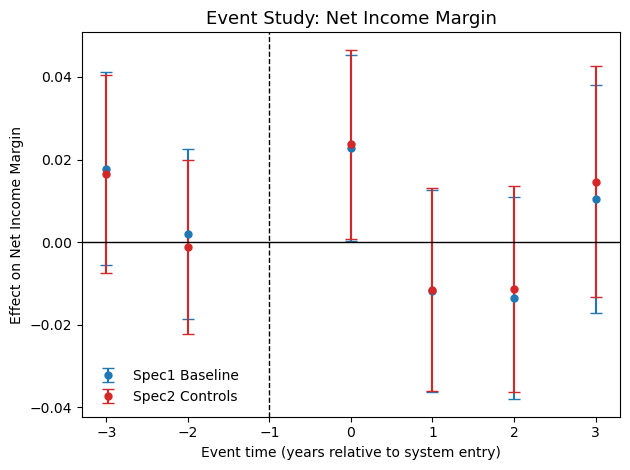

In [7]:
#Helper to convert event_m5/event_p2/event_0  to numeric event time
def parse_event_time(name: str) -> int:
    if name == "event_0":
        return 0
    m = re.match(r"event_m(\d+)$", name)
    if m:
        return -int(m.group(1))
    m = re.match(r"event_p(\d+)$", name)
    if m:
        return int(m.group(1))
    raise ValueError(f"Unrecognized event term: {name}")


colors = {
    "Spec1_baseline": "tab:blue",
    "Spec2_controls": "tab:red"
}

for spec in specs:
        tbl = results[("net_income_margin", spec)].copy()
        tbl["k"] = [parse_event_time(ix) for ix in tbl.index]
        tbl = tbl.sort_values("k")

        # point estimate + 95% CI
        y     = tbl["coef"].to_numpy()
        se    = tbl["se"].to_numpy()
        lower = tbl["ci_lower"].to_numpy()
        upper = tbl["ci_upper"].to_numpy()
        yerr  = np.vstack([y - lower, upper - y])

        plt.errorbar(
        tbl["k"],
        y,
        yerr=yerr,
        fmt="o",
        color=colors.get(spec, "black"),
        capsize=4,
        markersize=5,
        linewidth=1.5,
        label=spec.replace("_", " ").title()
        )

plt.axhline(0, color="black", linewidth=1)
plt.axvline(-1, linestyle="--", color="black", linewidth=1)
plt.xlabel("Event time (years relative to system entry)")
plt.ylabel("Effect on Net Income Margin")
plt.title("Event Study: Net Income Margin", fontsize=13)

plt.legend(frameon=False)
plt.tight_layout()
plt.show()

The plot displays point estimates for each event-time coefficient, with vertical error bars representing the 95% confidence intervals. Different colors distinguish the two specifications, allowing a direct comparison between the baseline model and the model that includes additional hospital controls. The horizontal line at zero represents no effect, while the vertical dashed line at event time −1 marks the omitted baseline period, so all coefficients are interpreted relative to the year immediately before system entry.


This event-study plot visually confirms the regression findings. The pre-treatment coefficients (event times less than zero) are clustered around zero and their confidence intervals overlap zero, indicating no evidence of differential pre-trends prior to system entry. This supports the parallel trends assumption underlying the difference-in-differences design.


Now, let's turn to the Robustness Checks
# 5. Robustness Checks

I will test:

1. **Pre-trends ("lead") joint test:** This test formally assesses the parallel trends assumption, which is the key identifying condition for the event-study design.
    - To achieve this, I jointly test whether the estimated coefficients on the pre-treatment event-time indicators (the leads) are equal to zero.
    - Failure to reject this null hypothesis indicates that treated and control hospitals followed similar trends before system entry, supporting the validity of the difference-in-differences approach.
3. **Placebo "fake event year" for never-treated controls:** as a falsification exercise, I assign artificial treatment dates to hospitals that never enter the system and re-estimate the event-study model.
    - Because these hospitals never experience the treatment, the estimated effects around the placebo event should be statistically indistinguishable from zero.
    - Finding no systematic effects in this placebo test increases confidence that the main results are not driven by spurious timing or mechanical features of the estimation procedure.
5. **“Shifted event" placebo (pretend treatment happens earlier):** The final robustness check shifts the treatment timing earlier than the true event date for treated hospitals and re-estimates the event-study model.
   - If the estimated effects reflect genuine causal impacts of system entry, no treatment-like pattern should emerge around this artificially shifted event.
   - This test helps rule out the possibility that the main results are driven by underlying trends or anticipatory dynamics rather than the timing of system affiliation itself.


Let's start testing the hypothesis of parallel trends. 
## 5.1 Pre-trends ("lead") joint test.
The null hypothesis is that all **pre-treatment event-study coefficients** (the leads) are jointly equal to zero:

$$
H_0: \beta_{k} = 0 \quad \text{for all } k < -1
$$

where $\beta_{-k}$ denotes the coefficient on the indicator for event time $-k$ (relative to the omitted baseline period $k = -1$). Here, I will be testing the null for $k=-2,-3$. The alternative hypothesis is that at least one pre-treatment coefficient differs from zero:

$$
H_1: \exists \, k > 1 \text{ such that } \beta_{-k} \neq 0
$$

Rejection of the null would indicate that treated and control hospitals were on **differential trends before treatment**, violating the parallel trends assumption. The test is implemented as a **Wald test** of linear restrictions on the estimated regression coefficients. Under the null hypothesis, the Wald statistic follows a chi-squared distribution:

$$
W \sim \chi^2(q)
$$

where $q$ is the number of pre-treatment coefficients being tested jointly. In this case, $q = 2$. Lastly, standard errors are clustered at the hospital level, so the test accounts for serial correlation in outcomes within hospitals over time. For more information about the test, *see* [this overview](https://www.tilburgsciencehub.com/topics/analyze/causal-inference/did/pretrends/) from the Tillburg University Science Hub.



In [8]:
# Test the pre-trend coefficients jointly
def lead_terms(event_window=(-5, 5)):
    leads = []
    for k in range(event_window[0], 0):
        if k == -1:
            continue
        leads.append(f"event_m{abs(k)}")
    return leads

leads = lead_terms(event_window=event_window)
print(leads)

restriction = ", ".join([f"{term} = 0" for term in leads])
print(restriction)
 
spec_list = list(specs.keys())
 
spec1 = models[("net_income_margin",spec_list[0])] 
print(spec1.wald_test(restriction))

spec2 = models[("net_income_margin",spec_list[1])] 
print(spec2.wald_test(restriction))

['event_m3', 'event_m2']
event_m3 = 0, event_m2 = 0
<F test: F=array([[1.41014099]]), p=0.2449034646127719, df_denom=610, df_num=2>
<F test: F=array([[1.45541918]]), p=0.23424407837869188, df_denom=524, df_num=2>


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


The joint Wald tests fail to reject the null hypothesis that the pre-treatment coefficients are equal to zero in both specifications of the Net Profit Margin. For the baseline model, the test yields an F-statistic of 1.41 with a p-value of 0.245, while the specification with controls yields an F-statistic of 1.46 with a p-value of 0.234. In both cases, the p-values are well above conventional significance thresholds (i.e $\alpha=0.05$ and $\alpha=0.1$), indicating no statistical evidence of differential pre-treatment trends in net income margins between treated and control hospitals. These results support the parallel trends assumption and reinforce the credibility of the event-study estimates for net income margin.


## 5.2 Placebo "fake event year" for never-treated controls:
Now, let's do the Placebo: “fake event year” for never-treated controls. The idea is to assign each never-treated hospital a random year in its observed years as a placebo event, build placebo event dummies, and run the event study. A successful test should report close to 0 and statistically insignificant effects.

Formally, for hospitals that are never treated, I randomly assign a placebo event year $ \tilde{t}_i $ from the set of years in which hospital $i$ is observed. I then define a placebo event-time variable:

$$
\widetilde{\text{event\_time}}_{it} = t - \tilde{t}_i
$$

and estimate the following placebo event-study specification:

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{k \neq -1} \widetilde{\beta}_k \cdot \mathbf{1}\{\widetilde{\text{event\_time}}_{it} = k\} + \varepsilon_{it}
$$

where $Y_{it}$ denotes the outcome of interest (net income margin), and the coefficients $\widetilde{\beta}_k $ capture changes in outcomes around the placebo event.

Because these hospitals never experience the treatment, the null hypothesis is that all placebo coefficients are equal to zero:

$$
H_0: \widetilde{\beta}_k = 0 \quad \text{for all } k
$$


Failure to reject this null hypothesis indicates that the event-study design does not mechanically generate treatment effects in the absence of true treatment. In other words, the absence of systematic effects around the placebo event increases confidence that the main results are not driven by spurious timing, model overfitting, or coincidental fluctuations in outcomes. Conversely, finding statistically significant placebo effects would suggest that the estimated treatment effects may reflect underlying trends or noise rather than a causal impact of system entry.

*See*  [Difference-in-Differences Designs: A Practitioner’s Guide](https://arxiv.org/pdf/2503.13323) for a detailed overview.


The next block of code constructs the placebo treatment timing for hospitals that never enter a system. For each never-treated hospital, I randomly assign a fake event year drawn from the set of years in which the hospital is observed. Using this artificial timing, I compute a placebo event-time variable and create a set of placebo event-time indicators over a symmetric window of −3 to +3 years (omitting −1 as the baseline). This step mirrors the construction of the true event-study variables, ensuring that any detected effects in the placebo analysis are not driven by differences in specification or variable construction.


In [9]:
# 1) Create placebo event_time for controls
rng = np.random.default_rng(123)

placebo_df = es_df.copy()

controls = placebo_df[placebo_df["treated"] == 0].copy()

fake_event_year = (
    controls.groupby("FAC_NO")["year"]
    .apply(lambda s: rng.choice(s.values))
    .rename("fake_event_year")
)

placebo_df = placebo_df.merge(fake_event_year, on="FAC_NO", how="left")

placebo_df["placebo_event_time"] = np.where(
    placebo_df["treated"] == 0,
    placebo_df["year"] - placebo_df["fake_event_year"],
    np.nan
)

# -------------------------------------------------------------------
# WINDOW = (-3, 3)
window_min, window_max = -3, 3

# 2) Create placebo event dummies for k in [-3,3], omit -1
for col in list(placebo_df.columns):
    if col.startswith("pl_event_"):
        placebo_df.drop(columns=col, inplace=True)

for k in range(window_min, window_max + 1):
    if k == -1:
        continue
    if k < 0:
        name = f"pl_event_m{abs(k)}"
    elif k > 0:
        name = f"pl_event_p{k}"
    else:
        name = "pl_event_0"

    placebo_df[name] = (placebo_df["placebo_event_time"] == k).astype(int)

# Build terms that match the created columns
pl_event_terms = " + ".join(
    [f"pl_event_m{abs(k)}" for k in range(window_min, 0) if k != -1] +
    ["pl_event_0"] +
    [f"pl_event_p{k}" for k in range(1, window_max + 1)]
)

print("Placebo terms:", pl_event_terms)

Placebo terms: pl_event_m3 + pl_event_m2 + pl_event_0 + pl_event_p1 + pl_event_p2 + pl_event_p3


Using the placebo constructed variables, the next code below estimates the placebo event-study regression using only never-treated hospitals. I regress net income margin on the placebo event-time indicators, including hospital and year fixed effects and clustering standard errors at the hospital level. Because these hospitals never experience the actual treatment, any statistically significant coefficients around the placebo event would indicate spurious dynamics or model artifacts. Conversely, the absence of systematic effects provides a falsification check that strengthens the causal interpretation of the main event-study results.

In [10]:
# 3) Run placebo regression (controls only)
placebo_controls = placebo_df[placebo_df["treated"] == 0].copy()
placebo_controls = placebo_controls[
    placebo_controls["placebo_event_time"].between(window_min, window_max)
].copy()

# (Sanity check: confirm dummy columns exist)
#missing = [t.strip() for t in pl_event_terms.split("+") if t.strip() not in placebo_controls.columns]
#print("Missing placebo columns (should be empty):", missing)

placebo_models = {}

for spec_name in spec_list:
    extra = specs[spec_name]

    formula_pl = f"net_income_margin ~ {pl_event_terms}{extra} + C(FAC_NO) + C(year)"
    m = smf.ols(formula_pl, data=placebo_controls).fit()

    used_idx = m.model.data.row_labels
    groups_used = placebo_controls.loc[used_idx, "FAC_NO"].to_numpy()

    m_cl = m.get_robustcov_results(cov_type="cluster", groups=groups_used)
    placebo_models[spec_name] = m_cl

    param_names = m_cl.model.exog_names
    coef        = pd.Series(m_cl.params, index=param_names)
    se          = pd.Series(m_cl.bse,   index=param_names)
    p_values    = pd.Series(m_cl.pvalues,   index=param_names)

    keep = [p for p in param_names if p.startswith("pl_event_")]
    out_tbl = pd.DataFrame({"coef": coef[keep], "se": se[keep], "p-value": p_values[keep]})

    print("\n" + "-" * 90)
    print(f"PLACEBO (fake event year, controls only) | {spec_name}")
    print(out_tbl.round(4))


------------------------------------------------------------------------------------------
PLACEBO (fake event year, controls only) | Spec1_baseline
               coef      se  p-value
pl_event_m3  0.0139  0.0094   0.1415
pl_event_m2 -0.0008  0.0084   0.9195
pl_event_0  -0.0026  0.0079   0.7431
pl_event_p1  0.0053  0.0091   0.5599
pl_event_p2 -0.0173  0.0097   0.0758
pl_event_p3 -0.0075  0.0102   0.4612

------------------------------------------------------------------------------------------
PLACEBO (fake event year, controls only) | Spec2_controls
               coef      se  p-value
pl_event_m3  0.0077  0.0116   0.5093
pl_event_m2 -0.0039  0.0110   0.7241
pl_event_0  -0.0000  0.0101   0.9968
pl_event_p1 -0.0021  0.0120   0.8613
pl_event_p2 -0.0193  0.0127   0.1306
pl_event_p3 -0.0195  0.0144   0.1764


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


The fake event year placebo provides a falsification check by assigning artificial treatment dates to hospitals that never enter a system. Across both specifications, the estimated placebo coefficients are small in magnitude, statistically insignificant, and display no systematic pattern around the placebo event. 

More specifically, the coefficients at the placebo event year are essentially zero, and the surrounding lead and lag coefficients fluctuate around zero without evidence of a discontinuity or persistent post-event trend. Although one post-placebo coefficient in the baseline specification is marginally significant at the 10 percent level, this effect disappears once controls are included and does not form part of a coherent dynamic pattern. Overall, these results indicate that the event-study framework does not mechanically generate treatment effects in the absence of true treatment, reinforcing the interpretation that the main net income margin results are driven by the actual timing of system entry rather than spurious correlations.



## 5.3 "Shifted event" placebo (pretend treatment happens earlier)

As a final falsification exercise, I implement a **shifted-event placebo** in which the treatment date is artificially moved **earlier** for hospitals that eventually enter a system. This test assesses whether the estimated event-study dynamics could be driven by underlying trends or anticipatory behavior rather than the true timing of system entry.

Formally, for treated hospitals, I redefine the event-time variable by shifting it forward by a fixed number of years (three years in this analysis):

$$
\widetilde{\text{event\_time}}_{it} = \text{event\_time}_{it} + 3
$$

Using this shifted event time, I re-estimate the event-study specification:

$$
Y_{it} = \alpha_i + \lambda_t + \sum_{k \neq -1} \widetilde{\beta}_k \cdot \mathbf{1}\{\widetilde{\text{event\_time}}_{it} = k\} + \varepsilon_{it}
$$

where the sample is restricted to **treated hospitals only**, and the event window is again limited to \(k \in \{-3,-2,-1,0,1,2,3\}\), with \(k = -1\) omitted as the reference period.

#### Null hypothesis

Because the shifted event does not correspond to the true timing of system entry, the null hypothesis is that all shifted-event coefficients are equal to zero:

$$
H_0: \widetilde{\beta}_k = 0 \quad \text{for all } k
$$

 
Under a valid causal interpretation of the main results, the shifted-event placebo should produce **coefficients close to zero** and **no systematic post-event pattern** around the fake treatment date. Observing a treatment-like dynamic in this placebo would suggest that the main event-study estimates may reflect underlying trends or anticipation effects rather than the causal impact of system entry. Conversely, the absence of such patterns strengthens the interpretation that the estimated effects are tied to the true timing of treatment.



In the code below, I focus on hospitals that eventually join a system and artificially shift the treatment date earlier than its true timing. Specifically, I redefine event time by adding three years to the original event-time variable, effectively pretending that system entry occurred three years sooner. I then restrict the sample to treated hospitals and to the same symmetric event window \([-3, 3]\) around this fake event. Using this shifted timeline, I construct a set of shifted event-time indicators (e.g., `sh_event_m3`, `sh_event_m2`, `sh_event_0`, `sh_event_p1`, `sh_event_p2`, `sh_event_p3`), omitting the year immediately before the fake treatment (\(-1\)) as the reference period. This mirrors the construction of the true event-study variables while intentionally misaligning the treatment timing.


In [11]:
shift = 3                 # shift event by +n (treat as if event happened n years earlier). 
outcome = "net_income_margin"

shift_df = es_df.copy()

#1) Create shifted event_time (treated only)
#If treated==1, then shift_event_time = event_time + shift
#If treated==0, then leave as NaN (we are not using controls in this placebo)

shift_df["shift_event_time"] = np.where(
    shift_df["treated"] == 1,
    shift_df["event_time"] + shift,
    np.nan
)

#2) Restrict to treated hospitals and event window  
shift_treated = shift_df[shift_df["treated"] == 1].copy()
shift_treated = shift_treated[
    shift_treated["shift_event_time"].between(window_min, window_max)
].copy()

 
#3) Drop old shifted dummy columns if re-running
 
for col in list(shift_treated.columns):
    if col.startswith("sh_event_"):
        shift_treated.drop(columns=col, inplace=True)

#4a) Create shifted event-time dummies (omit -1 as the reference period)
# sh_event_m3, sh_event_m2, sh_event_0, sh_event_p1, sh_event_p2, sh_event_p3 (ex for window size 3)
for k in range(window_min, window_max + 1):
    if k == -1:
        continue
    if k < 0:
        name = f"sh_event_m{abs(k)}"
    elif k > 0:
        name = f"sh_event_p{k}"
    else:
        name = "sh_event_0"
    shift_treated[name] = (shift_treated["shift_event_time"] == k).astype(int)

#4b) Build the RHS event terms string consistent with the created columns

sh_event_terms = " + ".join(
    [f"sh_event_m{abs(k)}" for k in range(window_min, 0) if k != -1] +
    ["sh_event_0"] +
    [f"sh_event_p{k}" for k in range(1, window_max + 1)]
)

 
print("Shifted placebo terms:", sh_event_terms)
print("Shifted placebo sample size:", len(shift_treated))
print("Shifted placebo hospitals:", shift_treated["FAC_NO"].nunique())

#Check for missing shifted (there should be none)
missing = [t.strip() for t in sh_event_terms.split("+") if t.strip() not in shift_treated.columns]
print("Missing shifted dummy columns (should be empty):", missing)

Shifted placebo terms: sh_event_m3 + sh_event_m2 + sh_event_0 + sh_event_p1 + sh_event_p2 + sh_event_p3
Shifted placebo sample size: 1034
Shifted placebo hospitals: 267
Missing shifted dummy columns (should be empty): []


Below, I estimate the shifted-event placebo regression, using net income margin as the outcome and the shifted event-time indicators as regressors, along with hospital and year fixed effects and clustered standard errors at the hospital level. Because the shifted event does not correspond to the true timing of system entry, a valid causal interpretation implies that these placebo coefficients should be close to zero and display no systematic post-event pattern. Observing null and patternless estimates around the fake event supports the interpretation that the main event-study results are tied to the actual timing of system affiliation rather than to underlying trends or anticipatory dynamics.

In [12]:
#5) Run the shifted-event placebo regressions (clustered by hospital) 
# Uses: net_income_margin ~ shifted_event_dummies + (any controls) + FE

shift_models = {}

for spec_name in spec_list:
    extra = specs[spec_name]  # "" for baseline, or " + ..." for controls

    formula_sh = f"{outcome} ~ {sh_event_terms}{extra} + C(FAC_NO) + C(year)"
    m = smf.ols(formula_sh, data=shift_treated).fit()

    # Align clusters to the rows actually used by Patsy/statsmodels
    used_idx = m.model.data.row_labels
    groups_used = shift_treated.loc[used_idx, "FAC_NO"].to_numpy()

    # Cluster-robust covariance
    m_cl = m.get_robustcov_results(cov_type="cluster", groups=groups_used)
    shift_models[spec_name] = m_cl

    #6) Print shifted placebo event coefficients (should be 0)
    param_names = m_cl.model.exog_names
    coef = pd.Series(m_cl.params, index=param_names)
    se   = pd.Series(m_cl.bse,   index=param_names)
    p_values    = pd.Series(m_cl.pvalues,   index=param_names)

    keep = [p for p in param_names if p.startswith("sh_event_")]
    out_tbl = pd.DataFrame({"coef": coef[keep], "se": se[keep], "p-value": p_values[keep]})

    print("\n" + "-" * 90)
    print(f"PLACEBO (shift event earlier by {shift}y, treated only) | {spec_name}")
    print(out_tbl.round(4))



------------------------------------------------------------------------------------------
PLACEBO (shift event earlier by 3y, treated only) | Spec1_baseline
               coef      se  p-value
sh_event_m3  0.0000  0.0000   0.0000
sh_event_m2  0.0000  0.0000   0.0000
sh_event_0   0.0163  0.0174   0.3506
sh_event_p1 -0.0278  0.0189   0.1425
sh_event_p2 -0.0392  0.0264   0.1388
sh_event_p3 -0.0783  0.0119   0.0000

------------------------------------------------------------------------------------------
PLACEBO (shift event earlier by 3y, treated only) | Spec2_controls
               coef      se  p-value
sh_event_m3 -0.0000  0.0000   0.0000
sh_event_m2 -0.0000  0.0000   0.0000
sh_event_0   0.0417  0.0231   0.0725
sh_event_p1  0.0104  0.0316   0.7423
sh_event_p2  0.0137  0.0434   0.7528
sh_event_p3 -0.0106  0.0367   0.7723


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))



The shifted-event placebo reassigns the treatment date to occur three years earlier for hospitals that eventually join a system, providing a falsification test for whether the estimated dynamics are driven by the true timing of system entry. In both specifications, the coefficients at the fake treatment date $(k = 0)$ are statistically insignificant, and there is no consistent or sustained post-event pattern across subsequent years. This absence of treatment-like dynamics around the artificially shifted event supports the interpretation that the main event-study results are not driven by underlying trends or anticipatory behavior.

Two pre-period coefficients $(k = -3)$ and $(k = -2)$ are mechanically equal to zero in both specifications, reflecting a lack of data support in those bins after shifting and window restriction rather than meaningful economic effects. In the baseline specification, one post-period coefficient $(k = 3)$ appears statistically significant; however, this effect disappears once controls are included and does not form part of a coherent dynamic pattern. Overall, the shifted-event placebo reinforces the conclusion that the observed increase in net income margin at the time of system entry is tied to the actual treatment timing rather than spurious dynamics.

# 5. Final Consideration: what does this effect mean?

I found that hospitals joining a system increase their net profit margin by an average of  2.37 percentage points. Using the Confidence Interval of the specification that includes full controls (0.0008,0.0466), I can conclude the following:
- Hospitals that never received treatment have an average 0.3888 percent net margin, while hospitals that received the treatment had a 3.9296 percent net margin before treatment. This means that Never Treated Hospitals are less profitable than Treated Hospitals.
- Given my assumption and robustness checks, the effect identified above shows that, upon joining a hospital system, most hospitals hospitals either:
- Remain virtually the same or slighlty worse  (4.0096 =3.9296+0.08)
- Increase their margin to 6.2996 percentage points on average (3.9296+2.37). This corresponds to  a 60% increase
- Increase their margin to 8.5896 percentage points or more (3.9296+4.66). This corresponds to a 118% increase


In [13]:
balance_nontreated = balance.loc[0, (slice(None), "mean")]["net_income_margin"]
balance_treated    = balance.loc[1, (slice(None), "mean")]["net_income_margin"]
spec_use           = results[("net_income_margin", "Spec2_controls")]
coef               = spec_use.loc["event_0", "coef"]
low_ci             = spec_use.loc["event_0", "ci_lower"]
hi_ci              = spec_use.loc["event_0", "ci_upper"]
print("Pre Treatment Mean (Non-Treated): ",balance_nontreated)
print("Pre Treatment Mean (Treated): ",balance_treated)
print("Average Effect of Joining a System: ",coef)
print("Lower CI Effect of Joining a System: ",low_ci)
print("Higher CI Effect of Joining a System: ",hi_ci)

#Calculate now for pre-treated
print("Profit Margin After Effect at the Average Treated Hospital: ",balance_treated+coef)
print("Profit Margin After Effect (Lower CI) at the Average Treated Hospital: ",balance_treated+low_ci)
print("Profit Margin After Effect (Higher CI) at the Average Treated Hospital: ",balance_treated+hi_ci)

Pre Treatment Mean (Non-Treated):  mean    0.003888
Name: 0.0, dtype: float64
Pre Treatment Mean (Treated):  mean    0.039296
Name: 1.0, dtype: float64
Average Effect of Joining a System:  0.023663901778246326
Lower CI Effect of Joining a System:  0.0007558140530176602
Higher CI Effect of Joining a System:  0.04657198950347499
Profit Margin After Effect at the Average Treated Hospital:  mean    0.06296
Name: 1.0, dtype: float64
Profit Margin After Effect (Lower CI) at the Average Treated Hospital:  mean    0.040051
Name: 1.0, dtype: float64
Profit Margin After Effect (Higher CI) at the Average Treated Hospital:  mean    0.085868
Name: 1.0, dtype: float64
